# Initialize system

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 23:00:09
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/noteboo

In [5]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

In [6]:
#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xbfffff


In [8]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [9]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()

descramble error
rawData length 7920
descramble error
rawData length 7920
descramble error
rawData length 48
descramble error
rawData length 26640


In [11]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


# Here we select which ASIC we want to test

In [13]:
# Change these 3 lines when you want to select another ASIC
AsicNum = 1
dataDebug = DEBUG1
ASIC = ASIC1

# From here it's all the same
root.enableAllAsics(False)
root.enableAsic(AsicNum, True)
root.enableDataRcv(False)

dataDebug.enableDataDebug(True) ##### -- This was changed !!!
dataDebug.cleanData() ##### -- This was changed !!!

# Lorenzo - Helper functions

In [14]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# ADC Response with external DAC single writes

In [15]:
ASIC.mTest.set(True)  # Enable external DAC
ASIC.DHg.set(True)    # Set High gain
ASIC.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC.RefGenB.set(2)   # Don't touch

In [17]:
# Set minimum and maximum values for DAC scan

DAC_minValue=0
DAC_maxValue=548575
DAC_step=50000
DAC_framesForEachStep=16

iterations = len(range(DAC_minValue, DAC_maxValue, DAC_step))

dataScan = np.empty((192,384,iterations))
DACScan  = np.empty(iterations)

#write to DAC

for i, DACValue in enumerate(range(DAC_minValue,DAC_maxValue,DAC_step)):
    print('Iteration {}/{}'.format(i,iterations))
    DAC.FastDac.DacValue.set(DACValue)
#     print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))
    DACScan[i] = DAC.FastDac.DacValueV.get()
    
    # Get data
    dataTemp = readoutFrames(dataDebug, 1, DAC_framesForEachStep)
    dataTemp = np.median(dataTemp, axis=2) 
    dataScan[:,:,i] = dataTemp

Iteration 0/11
Data Descrambled
(192, 384, 1)
Iteration 1/11
Data Descrambled
(192, 384, 1)
Iteration 2/11
Data Descrambled
(192, 384, 1)
Iteration 3/11
Data Descrambled
(192, 384, 1)
Iteration 4/11
Data Descrambled
(192, 384, 1)
Iteration 5/11
Data Descrambled
(192, 384, 1)
Iteration 6/11
Data Descrambled
(192, 384, 1)
Iteration 7/11
Data Descrambled
(192, 384, 1)
Iteration 8/11
Data Descrambled
(192, 384, 1)
Iteration 9/11
Data Descrambled
(192, 384, 1)
Iteration 10/11
Data Descrambled
(192, 384, 1)


# ChatGPT linear regression

In [18]:
from scipy.stats import linregress

x = DACScan
y = dataScan[0,383,:]


linear_ranges = []
min_points_in_range = 10  # Minimum number of points in a range for consideration

for i in range(len(x) - min_points_in_range + 1):
    for j in range(i + min_points_in_range, len(x) + 1):
        x_range = x[i:j]
        y_range = y[i:j]
        
        if len(x_range) >= min_points_in_range:
            slope, intercept, r_value, p_value, std_err = linregress(x_range, y_range)
            linear_ranges.append({
                'start_index': i,
                'end_index': j - 1,
                'r_squared': r_value ** 2,
                'slope': slope,
                'intercept': intercept
            })

linear_ranges.sort(key=lambda x: x['r_squared'], reverse=True)

best_linear_range = linear_ranges[0]
start_index = best_linear_range['start_index']
end_index = best_linear_range['end_index']

gain = best_linear_range['slope']
offset = best_linear_range['intercept']


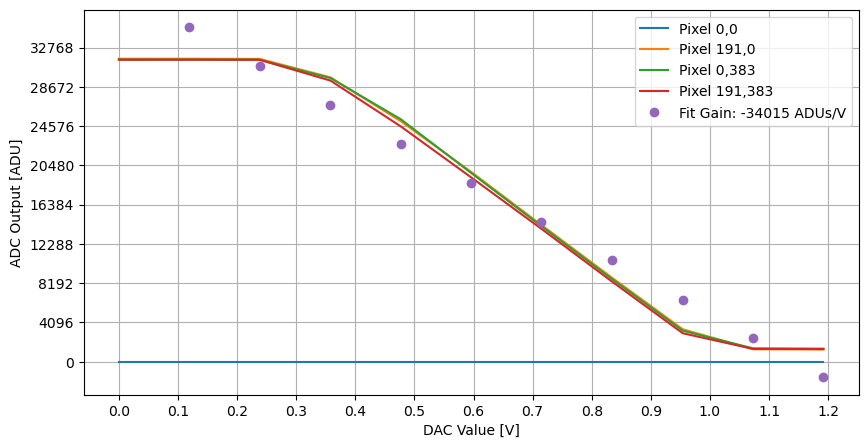

In [19]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize = (10,5))

plt.plot(DACScan,dataScan[0,0,:], label='Pixel 0,0')
plt.plot(DACScan,dataScan[191,0,:], label='Pixel 191,0')
plt.plot(DACScan,dataScan[0,383,:], label='Pixel 0,383')
plt.plot(DACScan,dataScan[191,383,:], label='Pixel 191,383')

plt.plot(x[start_index:end_index+1], best_linear_range['slope'] * x[start_index:end_index+1] + best_linear_range['intercept'], 'o', label='Fit Gain: {:.0f} ADUs/V'.format(gain))

plt.legend()



ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(4096))
plt.grid(True)

ax.set_ylabel('ADC Output [ADU]')
ax.set_xlabel('DAC Value [V]')


# Show the plots
plt.show()



# Check Pixel range

In [24]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(0)
ASIC.mTest.set(False)

# Optimal bias settings
ASIC.RefinN.set(3)
ASIC.RefinP.set(0)

ASIC.pipoclk_delay_row0.set(15)
ASIC.pipoclk_delay_row1.set(8)
ASIC.pipoclk_delay_row2.set(8)
ASIC.pipoclk_delay_row3.set(8)

# ADC settings
ASIC.DHg.set(False)    # Set High gain
ASIC.S2D_1_b.set(0)   # Set bias current to max (min value)
ASIC.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC.RefGenB.set(2)   # Don't touch

# Reference pixel
ref_row = 100
ref_col = 150

plt.figure(figsize = (10,5))

# Get ramps and calculate gain
ChInjValues, PixOutValues = chargeInjRamp(dataDebug,Min=0,Max=400,numSteps=10)



Data Descrambled
(192, 384, 1)
14353.0
Data Descrambled
(192, 384, 1)
14528.0
Data Descrambled
(192, 384, 1)
14523.0
Data Descrambled
(192, 384, 1)
14359.0
Data Descrambled
(192, 384, 1)
14059.0
Data Descrambled
(192, 384, 1)
13087.0
Data Descrambled
(192, 384, 1)
10132.0
Data Descrambled
(192, 384, 1)
7230.0
Data Descrambled
(192, 384, 1)
6128.0
Data Descrambled
(192, 384, 1)
5813.0


<Figure size 1000x500 with 0 Axes>

Noise:-0.0008819624101790982


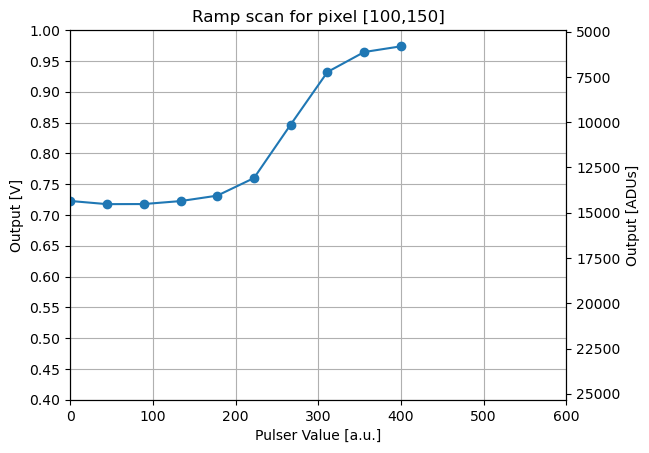

In [25]:
plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='{}/{}')
plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim(0.4, 1.0)  # Set y axis limits from -1 to 1

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.plot(ChInjValues, -1*PixOutValues)

plt.xlim(0, 600)  # Set x axis limits from 2 to 8
plt.ylim((0.4*gain+offset), (1.0*gain+offset))  # Set y axis limits from -1 to 1

plt.ylabel("Output [ADUs]")




plt.title('Ramp scan for pixel [{},{}]'.format(ref_row,ref_col))
ax.grid(True)

print('Noise:{}'.format(30/gain))

RefinP = 0
Data Descrambled
(192, 384, 1)
13732.0
Data Descrambled
(192, 384, 1)
13870.0
Data Descrambled
(192, 384, 1)
13807.0
Data Descrambled
(192, 384, 1)
13735.0
Data Descrambled
(192, 384, 1)
13401.0
Data Descrambled
(192, 384, 1)
12347.0
Data Descrambled
(192, 384, 1)
9406.0
Data Descrambled
(192, 384, 1)
6546.0
Data Descrambled
(192, 384, 1)
5355.0
Data Descrambled
(192, 384, 1)
5062.0
RefinP = 1
Data Descrambled
(192, 384, 1)
14020.0
Data Descrambled
(192, 384, 1)
14524.0
Data Descrambled
(192, 384, 1)
14527.0
Data Descrambled
(192, 384, 1)
14344.0
Data Descrambled
(192, 384, 1)
13969.0
Data Descrambled
(192, 384, 1)
12147.0
Data Descrambled
(192, 384, 1)
9032.0
Data Descrambled
(192, 384, 1)
6035.0
Data Descrambled
(192, 384, 1)
4861.0
Data Descrambled
(192, 384, 1)
4550.0
RefinP = 2
Data Descrambled
(192, 384, 1)
14564.0
Data Descrambled
(192, 384, 1)
15137.0
Data Descrambled
(192, 384, 1)
15065.0
Data Descrambled
(192, 384, 1)
14886.0
Data Descrambled
(192, 384, 1)
14332.0


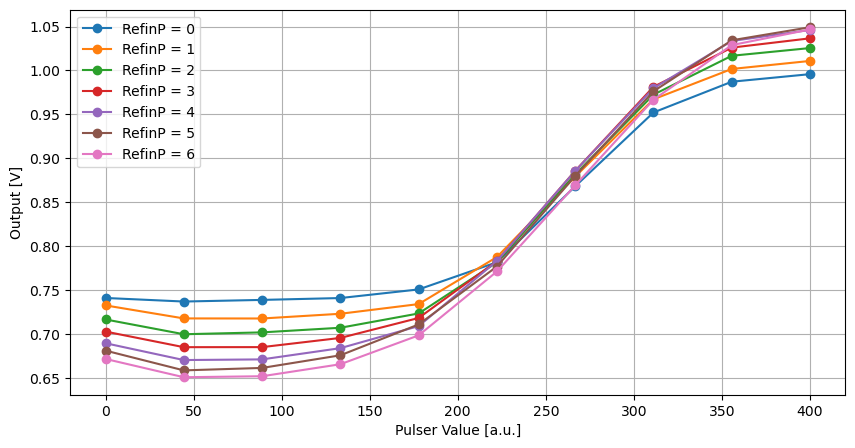

In [27]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(0)
ASIC.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC.RefinN.set(6)
ASIC.RefinP.set(1)

plt.figure(figsize = (10,5))

for RefinPValue in range(7):
    print('RefinP = {}'.format(RefinPValue))
    ASIC.RefinP.set(RefinPValue)
    # Get ramps and calculate gain
    ChInjValues, PixOutValues = chargeInjRamp(dataDebug,Min=0,Max=400,numSteps=10)
    plt.plot(ChInjValues, 1*((PixOutValues-offset))/gain,'o-', label='RefinP = {}'.format(RefinPValue))

plt.ylabel("Output [V]")
plt.xlabel("Pulser Value [a.u.]")
ax = plt.gca()
ax.grid(True)

plt.legend()


In [30]:
setR0(200, 200)
setAcq1(200, 400)
setSR0(40000, 1200)

# 100 = 0.64 uS

print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 
print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

R0 Width set to 1.280uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.280uS
Acq1 Delay set to 2.560uS
SR0 Width set to 238.095uS
SR0 Delay set to 7.143uS
R0 Width set to 1.280uS
R0 Delay set to 1.280uS
Acq1 Width set to 1.280uS
Acq1 Delay set to 2.560uS
SR0 Width set to 238.095uS
SR0 Delay set to 7.143uS
-------------------------
Baseline time:    1.28 uS
Integration time: 1.28 uS
Sampling done at: 3.84 uS
-------------------------


In [33]:
# Set some registers...
ASIC.CompTH_ePixM.set(0)

# Reference pixel
ref_row = 100
ref_col = 150

# Optimal bias settings
ASIC2.RefinN.set(4)
ASIC2.RefinP.set(0)

# Define integration time values
intTimeValues = [100,140,180,200,240,280,320,400,560,720,880,1040]

# Define empty arrays
noise   = np.empty(np.shape(intTimeValues)[0])
gain    = np.empty(np.shape(intTimeValues)[0])
intTimeValues_us = np.empty(np.shape(intTimeValues)[0])

setSR0(40000, 2000)

for i,intTime in enumerate(intTimeValues):
    print(f'--- Acquiring data value {intTime} ---')
    print(f'-------------------------')
    setR0(100+intTime*2, 200)
    setAcq1(intTime, intTime+200)
    baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
    integration_time = REGCTRL.AcqWidth1_us.get()
    print(f'Baseline time:    {baseline_int_time} uS')
    print(f'Integration time: {integration_time} uS')
    print(f'-------------------------')

    
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = chargeInjRamp(dataDebug,Min=220,Max=270,numSteps=4)
    gain[i] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(dataDebug ,100)
    data_noisemap = np.std(data, axis=2)    
    noise[i] = np.median(data_noisemap)
    intTimeValues_us[i] = REGCTRL.AcqWidth1_us.get()
    

print(noise)
print(gain)
print(intTimeValues_us)


SR0 Width set to 238.095uS
SR0 Delay set to 11.905uS
--- Acquiring data value 100 ---
-------------------------
R0 Width set to 1.920uS
R0 Delay set to 1.280uS
Acq1 Width set to 0.640uS
Acq1 Delay set to 1.920uS
Baseline time:    0.6399999999999999 uS
Integration time: 0.64 uS
-------------------------
Data Descrambled
(192, 384, 1)
13476.0
Data Descrambled
(192, 384, 1)
12382.0
Data Descrambled
(192, 384, 1)
11403.0
Data Descrambled
(192, 384, 1)
10159.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 140 ---
-------------------------
R0 Width set to 2.432uS
R0 Delay set to 1.280uS
Acq1 Width set to 0.896uS
Acq1 Delay set to 2.176uS
Baseline time:    0.8960000000000001 uS
Integration time: 0.896 uS
-------------------------
Data Descrambled
(192, 384, 1)
13266.0
Data Descrambled
(192, 384, 1)
11705.0
Data Descrambled
(192, 384, 1)
10700.0
Data Descrambled
(192, 384, 1)
9333.0
Data Descrambled
(192, 384, 100)
--- Acquiring data value 180 ---
-------------------------
R0 Width

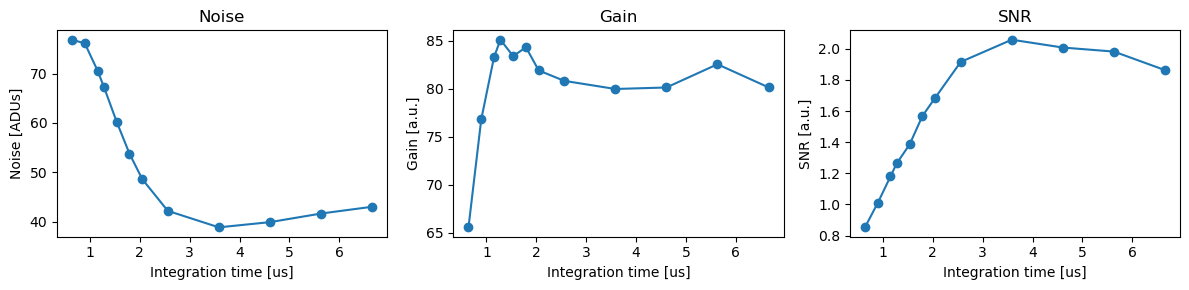

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

snr = abs(gain)/noise
axes[0].plot(intTimeValues_us,noise, 'o-')
axes[1].plot(intTimeValues_us,abs(gain), 'o-')
axes[2].plot(intTimeValues_us,snr, 'o-')

# Set titles for each subplot
axes[0].set_title('Noise')
axes[1].set_title('Gain')
axes[2].set_title('SNR')

axes[0].set_xlabel('Integration time [us]')
axes[1].set_xlabel('Integration time [us]')
axes[2].set_xlabel('Integration time [us]')

axes[0].set_ylabel('Noise [ADUs]')
axes[1].set_ylabel('Gain [a.u.]')
axes[2].set_ylabel('SNR [a.u.]')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

plt.tight_layout()
plt.show()


In [ ]:
# Set some registers...
ASIC2.CompTH_ePixM.set(0)

# Reference pixel
ref_row = 100
ref_col = 150


# Define integration time
setR0(420, 200)
setAcq1(160, 360)

baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'-------------------------')


# Define empty arrays

noise   = np.empty([8,8])
gain    = np.empty([8,8])

for RefN_val, RefP_val in np.ndindex(8,8):
    print('--- Acquiring data value {}/{} ---'.format(RefN_val,RefP_val))
    ASIC3.RefinN.set(RefN_val)
    ASIC3.RefinP.set(RefP_val)
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = ChInjRamp(DEBUG2, numberOfTriggers=3,Min=150,Max=200,numSteps=4)
    gain[RefN_val,RefP_val] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = readoutFrames(DEBUG2, 100)
    data_noisemap = np.std(data, axis=2)    
    noise[RefN_val,RefP_val] = np.median(data_noisemap)

print(noise)
print(gain)

In [ ]:
snr = abs(gain)/noise

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the images on each subplot
im1 = axes[0].imshow(abs(gain), cmap='viridis')
im2 = axes[1].imshow(noise, cmap='viridis')
im3 = axes[2].imshow(snr, cmap='viridis')

# Set titles for each subplot
axes[0].set_title('Gain')
axes[1].set_title('Noise')
axes[2].set_title('SNR')

axes[0].set_xlabel('RefInP')
axes[1].set_xlabel('RefInP')
axes[2].set_xlabel('RefInP')

axes[0].set_ylabel('RefInN')
axes[1].set_ylabel('RefInN')
axes[2].set_ylabel('RefInN')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

# Add colorbars to each subplot
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar3 = fig.colorbar(im3, ax=axes[2])

# Set colorbar labels (optional)
cbar1.set_label('Gain [ADU/PulserValue]')
cbar2.set_label('Noise [ADUs]')
cbar3.set_label('SNR [a.u.]')

# Show the plots
plt.tight_layout()
plt.show()

print('Recommended setting RefN/RefP:{}'.format(np.where(snr == snr.max())))
